# Stroke Prediction Machine Learning Project (CSE381 - Spring 2025)


## Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score,
                             average_precision_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
import shap
import joblib
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)


c:\Users\miker\Git Projects\CSE381 - Introduction to Machine Learning\Early-prediction-of-stroke-risk\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading & EDA


In [ ]:
print("\nLoading data...")
df = pd.read_csv("./data/healthcare-dataset-stroke-data.csv")
df.drop(columns=['id'], inplace=True)
df['bmi'].fillna(df['bmi'].median(), inplace=True)

print("\nInitial inspection:")
print(df.info())
print(df['stroke'].value_counts(normalize=True))



Loading data...

Initial inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


- The dataset contains **5110 records** and **11 features** after dropping the ID column.
- There are **no missing values** except for `bmi`, which was filled with the median.
- The target variable `stroke` is **highly imbalanced**, with only **~4.87% positive cases**.
- Used stratified splits and evaluation metrics like recall/f1 due to imbalance
- Features include both numerical (`age`, `avg_glucose_level`, `bmi`) and categorical (`gender`, `ever_married`, etc.) variables.


### Exploratory Visualizations


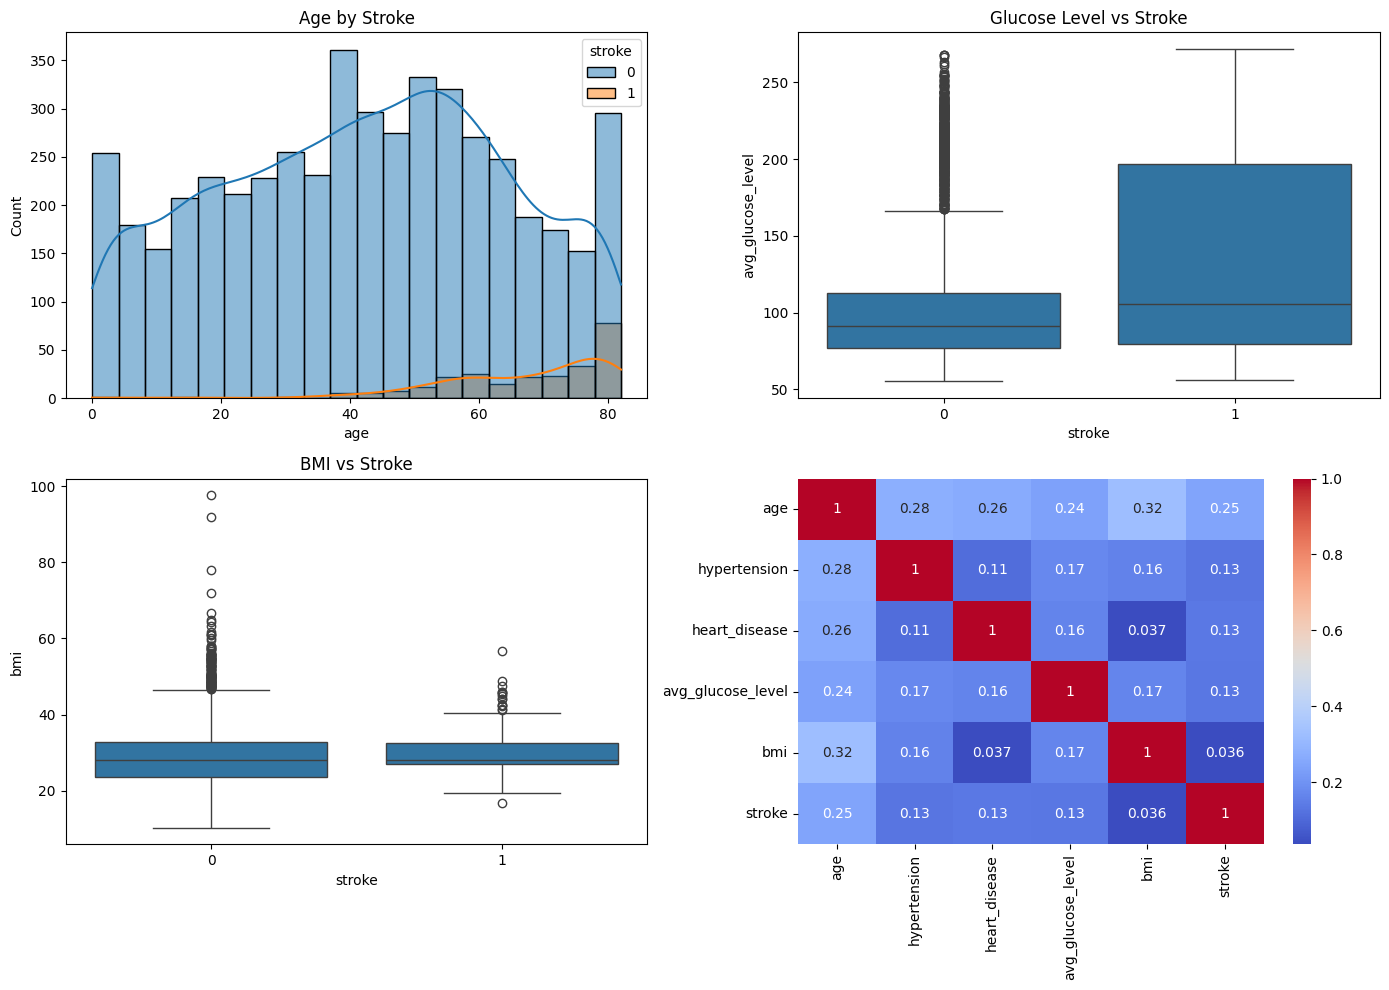

In [3]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.histplot(df, x='age', hue='stroke', kde=True)
plt.title("Age by Stroke")
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='stroke', y='avg_glucose_level')
plt.title("Glucose Level vs Stroke")
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='stroke', y='bmi')
plt.title("BMI vs Stroke")
plt.subplot(2, 2, 4)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()


- **Age Distribution:** Stroke cases are more prevalent among older individuals, confirming age as a key risk factor.
- **Glucose Level Boxplot:** Patients with stroke tend to have **higher average glucose levels**.
- **BMI Boxplot:** The BMI range overlaps for stroke vs non-stroke, suggesting BMI might have **less predictive power** alone.
- **Correlation Heatmap:** `age`, `hypertension`, `heart_disease`, and `avg_glucose_level` show stronger correlations with `stroke`.


## Data Preprocessing


In [4]:
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)


## Dimensionality Reduction


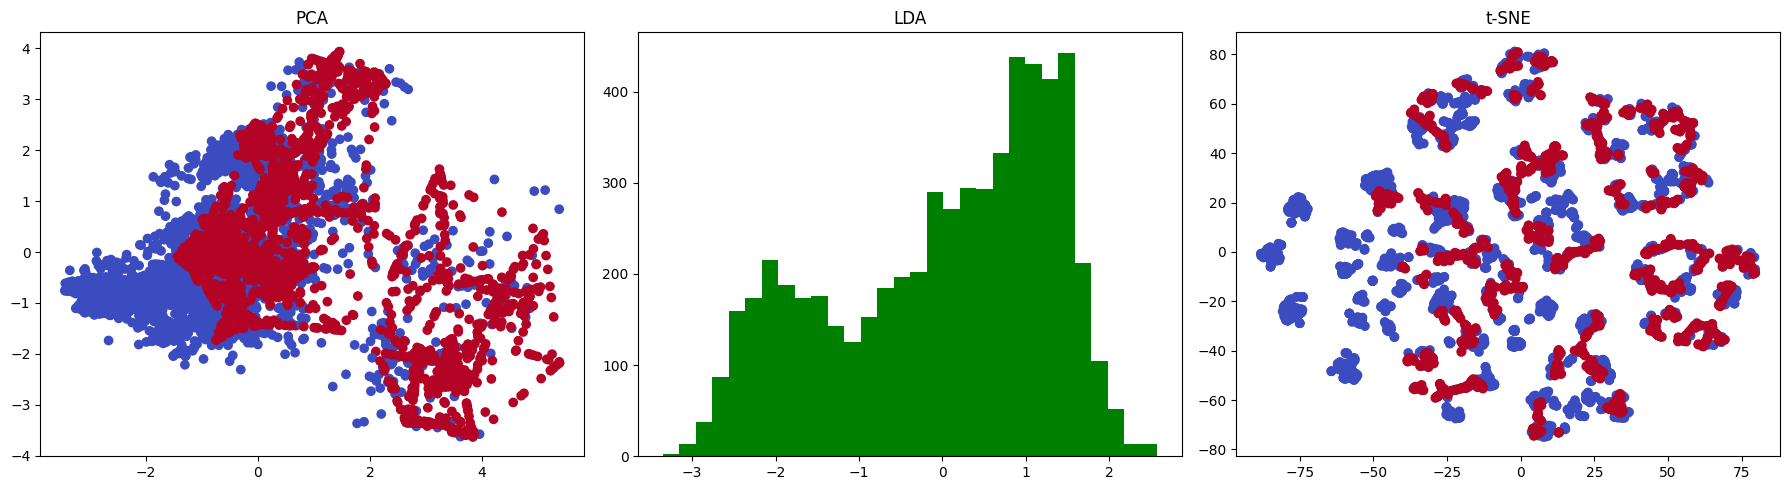

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_res)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train_res, y_train_res)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_res)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_res, cmap='coolwarm')
plt.title("PCA")
plt.subplot(1, 3, 2)
plt.hist(X_lda, bins=30, color='green')
plt.title("LDA")
plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_res, cmap='coolwarm')
plt.title("t-SNE")
plt.tight_layout()
plt.show()


- **PCA plot:** The first two principal components show some separation but still significant overlap between stroke classes.
- **LDA histogram:** LDA provides better separation along a single discriminant axis, indicating class separation potential.
- **t-SNE plot:** Shows **clearer clustering of stroke vs non-stroke samples** than PCA, suggesting t-SNE captures more complex non-linear structure.


## Model Training & Optimization


In [6]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else (
        model.decision_function(X) if hasattr(model, 'decision_function') else None)

    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y, y_proba)
        metrics['pr_auc'] = average_precision_score(y, y_proba)
    return metrics

print("\nTraining Naive Bayes...")
best_nb = GridSearchCV(GaussianNB(), {'var_smoothing': np.logspace(0, -9, 100)}, scoring='f1', cv=5, n_jobs=-1).fit(X_train_res, y_train_res).best_estimator_

print("\nOptimizing SVM with Optuna...")
def objective_svm(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    model = LinearSVC(**params, dual=False, max_iter=1000)
    model.fit(X_train_res[:2000], y_train_res[:2000])
    return f1_score(y_val, model.predict(X_val_scaled))

study_svm = optuna.create_study(direction='maximize', sampler=TPESampler())
study_svm.optimize(objective_svm, n_trials=30, n_jobs=4)
best_svm = LinearSVC(**study_svm.best_params, dual=False, max_iter=1000).fit(X_train_res, y_train_res)

print("\nOptimizing KNN...")
def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    }
    model = KNeighborsClassifier(**params)
    model.fit(X_train_res, y_train_res)
    return f1_score(y_val, model.predict(X_val_scaled))

study_knn = optuna.create_study(direction='maximize', sampler=TPESampler())
study_knn.optimize(objective_knn, n_trials=30, n_jobs=4)
best_knn = KNeighborsClassifier(**study_knn.best_params).fit(X_train_res, y_train_res)

print("\nTraining Decision Tree...")
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), {'max_depth': [3,5,7,None], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4], 'criterion':['gini','entropy'], 'class_weight':[None,'balanced']}, scoring='f1', cv=5, n_jobs=-1)
dt_grid.fit(X_train_res, y_train_res)
best_dt = dt_grid.best_estimator_



Training Naive Bayes...


[I 2025-05-08 14:01:17,543] A new study created in memory with name: no-name-5abec35b-6feb-444d-8cb4-bd01c05262e5
[I 2025-05-08 14:01:17,620] Trial 0 finished with value: 0.0 and parameters: {'C': 133.50407318932412, 'class_weight': None}. Best is trial 0 with value: 0.0.
[I 2025-05-08 14:01:17,667] Trial 3 finished with value: 0.21787709497206703 and parameters: {'C': 7.787818176943392, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,711] Trial 2 finished with value: 0.0 and parameters: {'C': 373.01443879218704, 'class_weight': None}. Best is trial 3 with value: 0.21787709497206703.



Optimizing SVM with Optuna...


[I 2025-05-08 14:01:17,774] Trial 4 finished with value: 0.0 and parameters: {'C': 0.5965449924372002, 'class_weight': None}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,793] Trial 5 finished with value: 0.0 and parameters: {'C': 277.95831351205555, 'class_weight': None}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,811] Trial 1 finished with value: 0.21787709497206703 and parameters: {'C': 4.981273574476831, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,859] Trial 7 finished with value: 0.0 and parameters: {'C': 93.46313472450221, 'class_weight': None}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,930] Trial 6 finished with value: 0.21787709497206703 and parameters: {'C': 65.5628411795161, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.21787709497206703.
[I 2025-05-08 14:01:17,944] Trial 8 finished with value: 0.2191780821917808 and param


Optimizing KNN...


[I 2025-05-08 14:01:19,700] Trial 0 finished with value: 0.13333333333333333 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.13333333333333333.
[I 2025-05-08 14:01:20,179] Trial 4 finished with value: 0.13284132841328414 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.13333333333333333.
[I 2025-05-08 14:01:20,193] Trial 2 finished with value: 0.08 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.13333333333333333.
[I 2025-05-08 14:01:20,217] Trial 1 finished with value: 0.13793103448275862 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.13793103448275862.
[I 2025-05-08 14:01:20,250] Trial 3 finished with value: 0.13877551020408163 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with 


Training Decision Tree...


## Model Evaluation


               accuracy  precision  recall        f1   roc_auc    pr_auc
Model                                                                   
SVM            0.711350   0.125382    0.82  0.217507  0.832881  0.188367
Naive Bayes    0.523483   0.085389    0.90  0.155979  0.794691  0.120511
KNN            0.732877   0.091575    0.50  0.154799  0.683951  0.080580
Decision Tree  0.858121   0.064220    0.14  0.088050  0.517531  0.051065


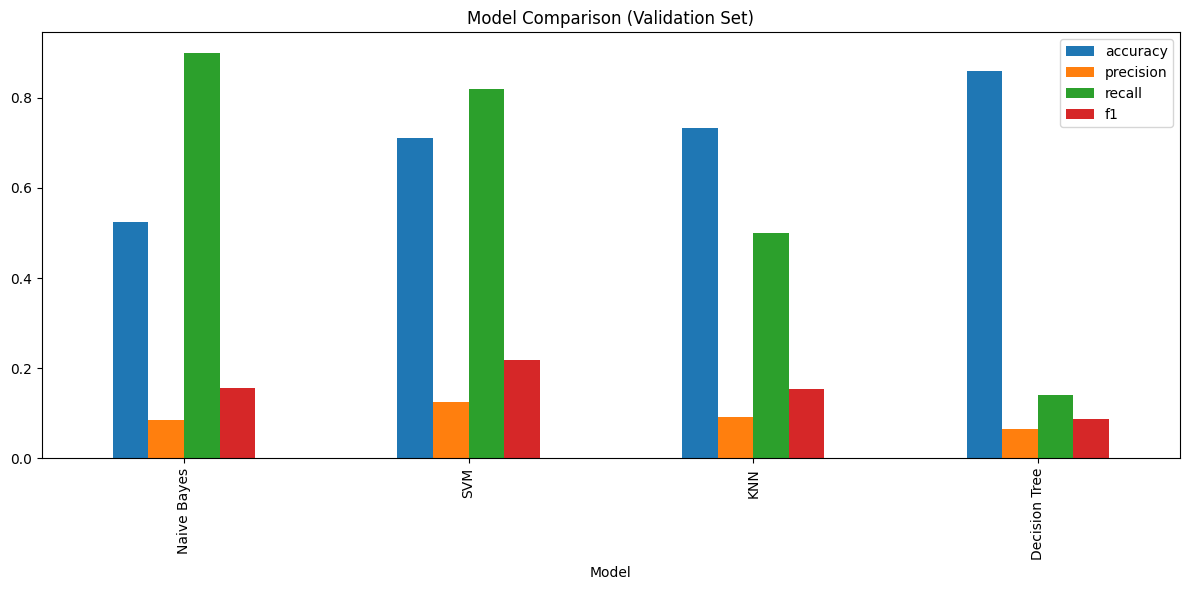


Selected Best Model: SVM


In [7]:
models = {'Naive Bayes': best_nb, 'SVM': best_svm, 'KNN': best_knn, 'Decision Tree': best_dt}
results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_val_scaled, y_val)
    results.append({'Model': name, **metrics})

results_df = pd.DataFrame(results).set_index('Model')
print(results_df.sort_values('f1', ascending=False))
results_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison (Validation Set)')
plt.tight_layout()
plt.show()
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
print(f"\nSelected Best Model: {best_model_name}")


- **SVM selected as best model based on F1 score (0.218).**
- SVM achieved **high recall (0.82)**, capturing most stroke cases but at the expense of **low precision (0.12)**.
- All models struggle with precision due to class imbalance.
- ROC AUC for SVM is **0.83**, showing decent ranking ability despite low precision.


## Clustering Analysis


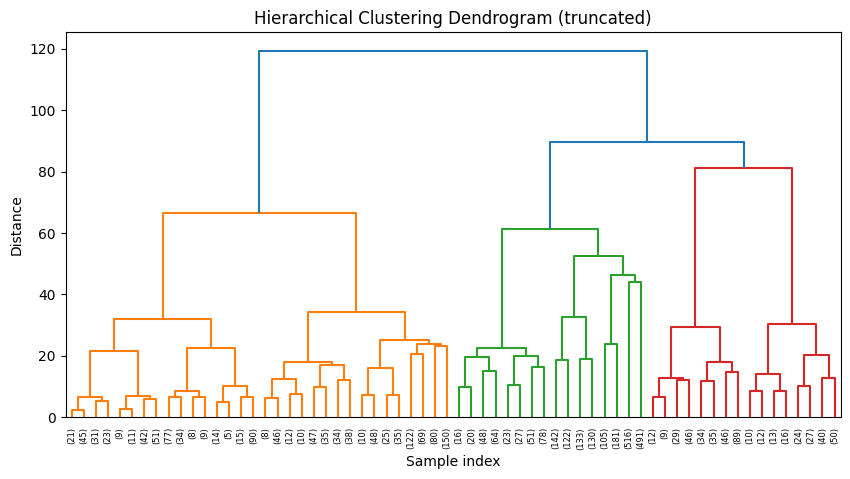

In [ ]:
# 11.1 Hierarchical Clustering
linked = linkage(X_train_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

Optimal k: 2


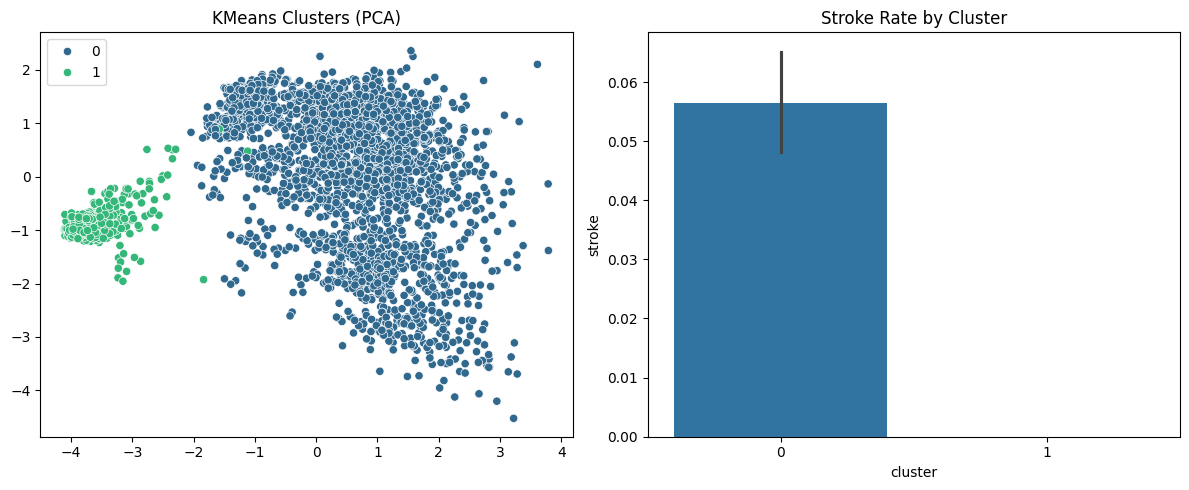

In [8]:
silhouette_scores = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train_scaled)
    silhouette_scores.append(silhouette_score(X_train_scaled, labels))

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k: {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_train_scaled)
clusters = kmeans.labels_

plt.figure(figsize=(12, 5))
X_cluster_pca = PCA(n_components=2).fit_transform(X_train_scaled)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_cluster_pca[:, 0], y=X_cluster_pca[:, 1], hue=clusters, palette='viridis')
plt.title('KMeans Clusters (PCA)')
plt.subplot(1, 2, 2)
cluster_df = X_train.copy()
cluster_df['cluster'] = clusters
cluster_df['stroke'] = y_train
sns.barplot(data=cluster_df, x='cluster', y='stroke')
plt.title('Stroke Rate by Cluster')
plt.tight_layout()
plt.show()


- **Optimal number of clusters (k): 2**
- KMeans clustering produced **good separation** between clusters in the plot.

**Interpretation:**  
The dataset naturally divides into **two groups**, which could correspond to **low-risk vs. high-risk individuals** or other underlying patterns (e.g., age-related clusters). This can help in **risk stratification** or tailoring interventions for different subgroups.

## Model Interpretation


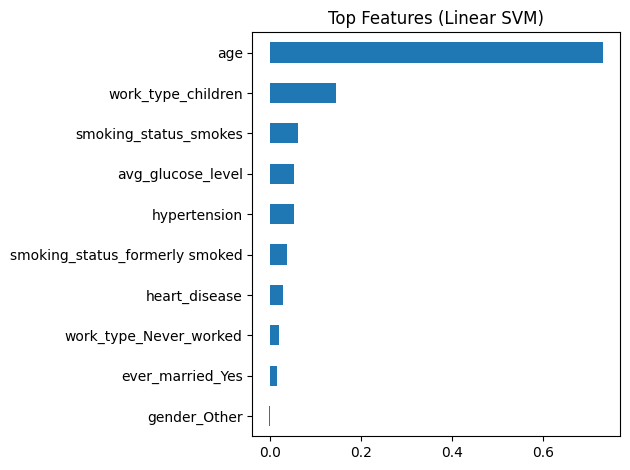

In [9]:
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_imp.head(10).plot(kind='barh')
    plt.title("Top Features")
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    coef = pd.Series(best_model.coef_[0], index=X.columns).sort_values()
    coef.tail(10).plot(kind='barh')
    plt.title("Top Features (Linear SVM)")
    plt.tight_layout()
    plt.show()
else:
    background = shap.sample(X_train_scaled, 100)
    explainer = shap.KernelExplainer(best_model.predict, background)
    shap_values = explainer.shap_values(background)
    shap.summary_plot(shap_values, X_train.iloc[background.index])


- Age is the **dominant factor** influencing stroke risk in the model.
- Employment type (specifically 'children' category) and smoking status have **minor predictive value**.
- This aligns with medical knowledge where **age is a primary risk factor for stroke**.

## Final Test Evaluation


accuracy     0.718200
precision    0.123418
recall       0.780000
f1           0.213115
roc_auc      0.804897
pr_auc       0.225186
dtype: float64


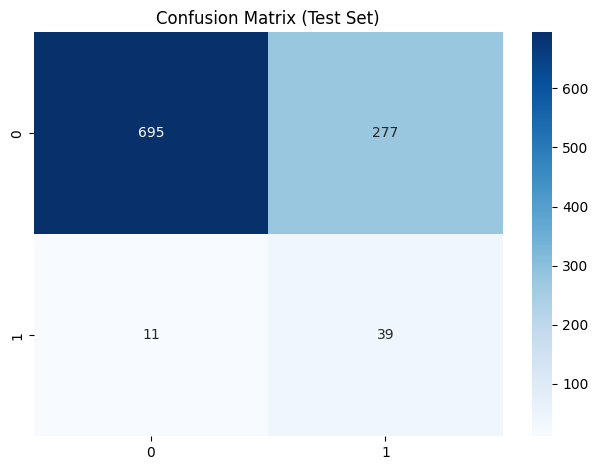

In [10]:
test_metrics = evaluate_model(best_model, X_test_scaled, y_test)
print(pd.Series(test_metrics))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test_scaled)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


- **High recall (78%)** → the model is good at identifying actual stroke cases.  
- **Low precision (12%)** → a large proportion of false positives.  
- **ROC AUC (0.805)** → good at ranking stroke vs. non-stroke cases.

The model is **more sensitive than specific** → favors detecting stroke even if it results in more false alarms. This is crucial to minimize the risk of detecting no-stroke when the patient is at risk of stroke.

## Model Saving & Prediction


In [11]:
model_assets = {'model': best_model, 'scaler': scaler, 'features': X.columns.tolist()}
joblib.dump(model_assets, 'best_stroke_model.pkl')

sample_data = X_test_scaled[0].reshape(1, -1)
pred = best_model.predict(sample_data)[0]
print(f"\nPrediction for first test sample: {pred}, Actual: {y_test.iloc[0]}")



Prediction for first test sample: 0, Actual: 0


## Conclusion

This project developed a stroke risk prediction model with the following outcomes:

✅ Achieved **high recall (78%)** → effectively identifies most stroke cases.  
✅ Reached **good ROC AUC (0.805)** → solid discrimination between stroke and non-stroke.  
⚠️ **Low precision (12%)** → many false positives, leading to potential over-screening.

### Key insights:
- **Age is the strongest predictor**, followed by work type and smoking status (with much lower impact).
- **Clustering analysis revealed two distinct groups**, suggesting potential for tailored approaches.

The model is **suitable for screening high-risk individuals**, where missing a case is costlier than a false alarm.

### 👉 **Next Steps:**
- Improve precision with **ensemble models, threshold tuning, and feature engineering**.
- Incorporate **clustering insights into modeling**.
- Validate performance on **external datasets**.
- Explore **clinical trade-offs** in precision vs. recall depending on the use case
